In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  

pd.set_option('display.max_columns', None)  # Show all columns in the DataFrame

In [3]:
data_path = "../data/silver/mta_weather_merged.parquet"

# Load the data
df = pd.read_parquet(data_path)

# Verify the connection
print(f"Data loaded successfully! Shape: {df.shape}")

Data loaded successfully! Shape: (165647, 36)


In [6]:
df_daily = df.groupby('transit_date').agg({
    'daily_ridership': 'sum',
    'temp': 'mean',
    'precip': 'mean',
    'snow': 'mean'
}).sort_index()


In [7]:
print(df_daily.isnull().sum())

daily_ridership    0
temp               0
precip             0
snow               0
dtype: int64


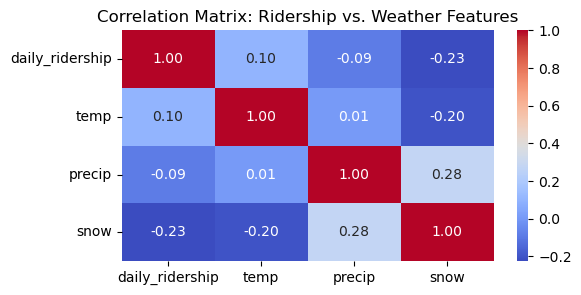

In [10]:
plt.figure(figsize=(6, 3))
sns.heatmap(df_daily.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Ridership vs. Weather Features")
plt.show()

NameError: name 'decomposition' is not defined

In [12]:
from statsmodels.tsa.stattools import adfuller

# Run on the city-wide total
df_city = df.groupby('transit_date')['daily_ridership'].sum()
result = adfuller(df_city)

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -3.7505480438646943
p-value: 0.0034557904656829647


In [13]:
# Grouping everything by date to see the city-wide trend
df_city = df.groupby('transit_date').agg({
    'daily_ridership': 'sum',
    'temp': 'mean',
    'precip': 'sum',
    'snow': 'sum',
    'icon': lambda x: x.mode()[0] # The most common weather for the day
}).reset_index()

In [68]:
df.isnull().sum()

transit_date             0
station_complex          0
borough                  0
daily_ridership          0
name                     0
tempmax                  0
tempmin                  0
temp                     0
feelslikemax             0
feelslikemin             0
feelslike                0
dew                      0
humidity                 0
precip                   0
precipprob               0
precipcover              0
preciptype          104325
snow                     0
snowdepth                0
windgust                 0
windspeed                0
winddir                  0
sealevelpressure         0
cloudcover               0
visibility               0
solarradiation           0
solarenergy              0
uvindex                  0
severerisk          165647
sunrise                  0
sunset                   0
moonphase                0
conditions               0
description              0
icon                     0
stations                 0
dtype: int64

In [71]:
df['month'] = df['transit_date'].dt.month
df['day_of_week'] = df['transit_date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['is_weekend'] = df['transit_date'].dt.dayofweek.isin([5, 6]).astype(int)

In [72]:
# Identify columns with only 1 unique value
single_value_cols = [col for col in df.columns if df[col].nunique() <= 1]
print(f"Columns with no variance: {single_value_cols}")

Columns with no variance: ['name', 'severerisk']


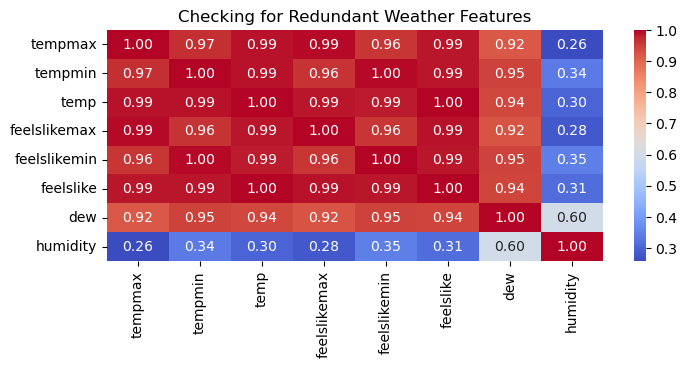

In [ ]:
# Check for multicollinearity
weather_cols = ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity']

# Generate a correlation matrix
correlation_matrix = df[weather_cols].corr()

plt.figure(figsize=(8, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Checking for Redundant Weather Features")
plt.show()

In [75]:
# Check for variety and overlap in weather descriptions
for col in ['conditions', 'icon', 'description']:
    print(f"Unique values in {col}: {df[col].nunique()}")
    print(df[col].value_counts().head(5))
    print("\n")

Unique values in conditions: 10
conditions
Partially cloudy                55133
Clear                           47939
Rain, Partially cloudy          34927
Rain, Overcast                  12986
Snow, Rain, Partially cloudy     6276
Name: count, dtype: int64


Unique values in icon: 6
icon
partly-cloudy-day    54709
rain                 52104
clear-day            47939
snow                  8376
cloudy                2095
Name: count, dtype: int64


Unique values in description: 44
description
Clear conditions throughout the day.                         47939
Partly cloudy throughout the day.                            37031
Becoming cloudy in the afternoon.                            11793
Partly cloudy throughout the day with early morning rain.     6326
Clearing in the afternoon.                                    6309
Name: count, dtype: int64




<Axes: xlabel='transit_date'>

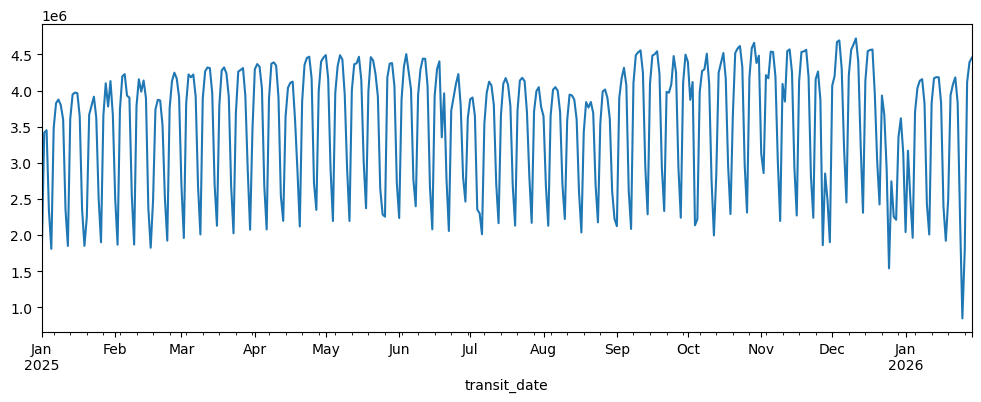

In [76]:
df.groupby("transit_date")["daily_ridership"].sum().plot(figsize=(12,4))


<Axes: xlabel='day_of_week'>

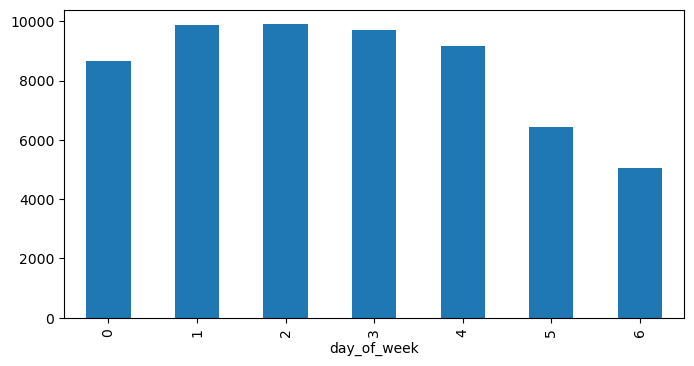

In [83]:
df.groupby("day_of_week")["daily_ridership"].mean().plot(kind='bar', figsize=(8,4) )

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

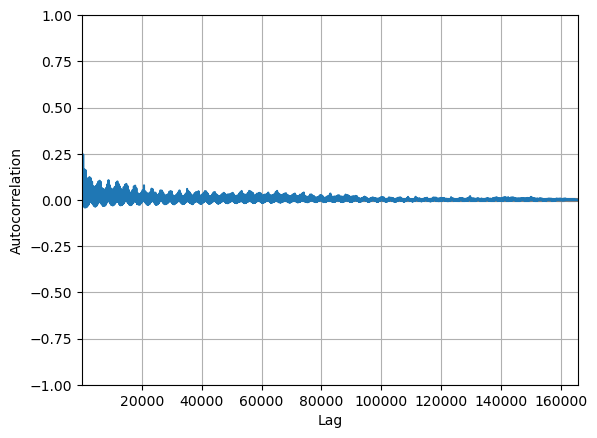

In [84]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df["daily_ridership"])


In [ ]:
# Check for correlation with ridership
check_cols = [
    'moonphase', 'solarenergy', 'uvindex', 'cloudcover', 
    'sealevelpressure', 'precipprob', 'daily_ridership', 'snow', 'snowdepth'
]

final_check = df[check_cols].corr()['daily_ridership'].sort_values()
print(final_check)

Feature selection:
1. Removed columns 'name', 'stations', 'severrisk' due to redundant values.
2. Removed cols 'tempmax', 'tempmin', 'feelslike', 'feelslikemax', 'feelslikemin', 'dew' due to high correlation (>0.94) with 'temp' (multicollinearity)
3. Removed 'conditions', 'description' and kept 'icon' as the primary categorical weather feature for cleaner labels.
4. Removed column 'preciptype' due to missing data.
5. Removed astro-physical and secondary weather columns like 'precipprob', 'precipcover', 'preciptype', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'sunrise', 'sunset', ''moonphase'. These columns also have a very low correlation with ridership.


In [69]:
df.columns

Index(['transit_date', 'station_complex', 'borough', 'daily_ridership', 'name',
       'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'severerisk', 'sunrise', 'sunset',
       'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

In [ ]:
# Check which one correlates better with your 'ridership_diff' (the signal you found earlier)
# ridership_diff = daily_ridership - roll_7_mean
print(df[['ridership_diff', 'snow', 'snowdepth']].corr()['ridership_diff'])

In [ ]:
# Check how ridership is distributed across boroughs
print(df.groupby('borough')['daily_ridership'].describe())

# Check for any "Station Complex" names that might need cleaning
print(f"Total Unique Station Complexes: {df['station_complex'].nunique()}")

In [ ]:
essential_cols = [
    'transit_date', 'station_complex', 'borough', 'daily_ridership',
    'temp', 'feelslike', 'precip', 'snow', 'snowdepth', 
    'conditions', 'visibility', 'windspeed'
]

df_eda = df[essential_cols].copy()

In [ ]:
df_eda.head()

In [ ]:
df_eda.isnull().sum()

In [ ]:
df_eda.info()

In [ ]:
# Convert to datetime if you haven't yet
df['transit_date'] = pd.to_datetime(df['transit_date'])

# Extract Day of Week
df['day_of_week'] = df['transit_date'].dt.day_name()

# Check ridership by Day of Week
weekly_pattern = df.groupby('day_of_week')['daily_ridership'].mean().sort_values()
print(weekly_pattern)

# Visualizing the 'Pulse'
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='transit_date', y='daily_ridership', errorbar=None)
plt.title("Ridership Over Time (Total System)")
plt.show()

In [ ]:
df_eda.sample(10)

In [ ]:
df_eda['borough'].value_counts()

In [ ]:
df_eda['station_complex'].nunique()

In [ ]:
df_eda['conditions'].value_counts()

In [ ]:
df.corr(numeric_only=True)["daily_ridership"].sort_values()

In [ ]:
df_eda.groupby(["is_weekend", df["precip"] > 0])["daily_ridership"].mean()

In [ ]:
df_eda.groupby(df["snow"] > 0)["daily_ridership"].mean()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot A: Ridership by Day of Week across Boroughs
plt.figure(figsize=(12, 6))
sns.barplot(data=df_eda, x='day_of_week', y='daily_ridership', hue='borough')
plt.title("Weekly Ridership Pulse by Borough")
plt.show()

In [ ]:
df_eda = df_eda.sort_values(['station_complex', 'transit_date'])

df_eda['ridership_lag_1'] = df_eda.groupby('station_complex')['daily_ridership'].shift(1)
df_eda['ridership_lag_7'] = df_eda.groupby('station_complex')['daily_ridership'].shift(7)

df_eda['ridership_roll_7'] = df_eda.groupby('station_complex')['daily_ridership'].transform(
    lambda x: x.rolling(window=7).mean()
)

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

# 1. Pick one station with a lot of data
station_name = df_eda['station_complex'].value_counts().index[0] 
station_data = df_eda[df_eda['station_complex'] == station_name].sort_values('transit_date')

# 2. Plot PACF
# 'lags=30' looks at the last month of data
plt.figure(figsize=(10, 5))
plot_pacf(station_data['daily_ridership'].dropna(), lags=30, method='ywm')
plt.title(f"Partial Autocorrelation for {station_name}")
plt.xlabel("Lags (Days)")
plt.ylabel("Correlation Strength")
plt.show()

In [ ]:
# In your notebook:
df_eda['ridership_diff'] = df_eda['daily_ridership'] - df_eda['ridership_roll_7']

# Does heavy rain correlate with a negative difference?
df_eda.groupby(df_eda['precip'] > 0.5)['ridership_diff'].mean()